In [1]:
%load_ext autoreload

In [2]:
%run "./common_init.ipynb"

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [3]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pickle

Using TensorFlow backend.


In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "../../"
CHAPTER_ID = "feature_extraction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures", CHAPTER_ID)

if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

## Finding relevant features

In [20]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test.pd.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_test.pd.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values
X_test = kdd98_test_feat.values
y_test = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

In [35]:
kdd98_learn_feat.describe()

,RECINHSE,AGE,AGEFLAG,HOMEOWNR,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBBOOKS,...,RFA_24R_P,RFA_24R_S,RFA_24R_U,RFA_24R_nan,DOMAINUrbanicity_C,DOMAINUrbanicity_R,DOMAINUrbanicity_S,DOMAINUrbanicity_T,DOMAINUrbanicity_U,DOMAINUrbanicity_nan
count,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,...,76329.000000,76329.000000,76329.000000,76329.0,76329.000000,76329.000000,76329.000000,76329.000000,76329.000000,76329.0
mean,0.070746,61.449201,0.854659,-0.863716,1.364048,1.714437,6.717558,3.321634,0.086531,0.777084,...,0.099508,0.177269,0.000307,0.0,0.204292,0.213531,0.229232,0.221255,0.130092,0.0
std,0.256402,14.900026,0.286464,45.037617,0.359500,61.237378,15.171171,9.177437,0.433996,1.242794,...,0.267212,0.355014,0.015785,0.0,0.541232,0.408701,0.506772,0.672556,0.333819,0.0
min,0.000000,1.000000,-0.211835,-730.838982,-0.638993,-1010.384878,-423.716602,0.000000,-4.948830,-3.631724,...,-0.104695,-0.298597,-0.012515,0.0,-10.780329,-0.738482,-12.112740,-4.536081,-0.349886,0.0
25%,0.000000,51.000000,0.827223,0.000000,1.162586,2.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,61.123079,1.000000,1.000000,1.317721,4.000000,6.665674,0.000000,0.000000,0.497027,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,72.000000,1.000000,1.000000,1.485394,5.000000,9.000000,3.000000,0.065181,1.000000,...,0.004415,0.122632,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,98.000000,1.418120,1289.931072,7.000000,1735.805410,269.630100,241.000000,8.478668,14.426068,...,1.263528,1.961900,1.000000,0.0,4.204680,2.223565,2.851415,16.153102,1.439049,0.0


In [36]:
kdd98_learn_targets.describe()

,TARGET_B,TARGET_D
count,76329.000000,76329.000000
mean,0.050754,0.799556
std,0.219496,4.493090
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,200.000000


### Boruta

In [6]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [7]:
help(BorutaPy)

Help on class BorutaPy in module boruta.boruta_py:

class BorutaPy(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Improved Python implementation of the Boruta R package.
 |  
 |  The improvements of this implementation include:
 |  - Faster run times:
 |      Thanks to scikit-learn's fast implementation of the ensemble methods.
 |  - Scikit-learn like interface:
 |      Use BorutaPy just like any other scikit learner: fit, fit_transform and
 |      transform are all implemented in a similar fashion.
 |  - Modularity:
 |      Any ensemble method could be used: random forest, extra trees
 |      classifier, even gradient boosted trees.
 |  - Two step correction:
 |      The original Boruta code corrects for multiple testing in an overly
 |      conservative way. In this implementation, the Benjamini Hochberg FDR is
 |      used to correct in each iteration across active features. This means
 |      only those features are included in the correction which are still in
 |  

In [8]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto',
                         max_iter=120,
                         verbose=2,
                         random_state=Config.get("random_seed"))

In [9]:
# find all relevant features
feat_selector.fit(kdd98_learn_feat.values, kdd98_learn_targets.TARGET_B.values)

Iteration: 	1 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	2 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	3 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	4 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	5 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	6 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	7 / 120
Confirmed: 	0
Tentative: 	653
Rejected: 	0
Iteration: 	8 / 120
Confirmed: 	90
Tentative: 	98
Rejected: 	465


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 120
Confirmed: 	90
Tentative: 	98
Rejected: 	465


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 120
Confirmed: 	90
Tentative: 	98
Rejected: 	465


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 120
Confirmed: 	90
Tentative: 	98
Rejected: 	465


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 120
Confirmed: 	98
Tentative: 	66
Rejected: 	489


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 120
Confirmed: 	98
Tentative: 	66
Rejected: 	489


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 120
Confirmed: 	98
Tentative: 	66
Rejected: 	489


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 120
Confirmed: 	98
Tentative: 	66
Rejected: 	489


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 120
Confirmed: 	99
Tentative: 	58
Rejected: 	496


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 120
Confirmed: 	99
Tentative: 	58
Rejected: 	496


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 120
Confirmed: 	99
Tentative: 	58
Rejected: 	496


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 120
Confirmed: 	99
Tentative: 	51
Rejected: 	503


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 120
Confirmed: 	99
Tentative: 	51
Rejected: 	503


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 120
Confirmed: 	99
Tentative: 	51
Rejected: 	503


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 120
Confirmed: 	100
Tentative: 	50
Rejected: 	503


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 120
Confirmed: 	100
Tentative: 	46
Rejected: 	507


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 120
Confirmed: 	100
Tentative: 	46
Rejected: 	507


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 120
Confirmed: 	100
Tentative: 	46
Rejected: 	507


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 120
Confirmed: 	101
Tentative: 	41
Rejected: 	511


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 120
Confirmed: 	101
Tentative: 	41
Rejected: 	511


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 120
Confirmed: 	101
Tentative: 	41
Rejected: 	511


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 120
Confirmed: 	102
Tentative: 	40
Rejected: 	511


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 120
Confirmed: 	102
Tentative: 	37
Rejected: 	514


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 120
Confirmed: 	102
Tentative: 	37
Rejected: 	514


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 120
Confirmed: 	102
Tentative: 	33
Rejected: 	518


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 120
Confirmed: 	102
Tentative: 	33
Rejected: 	518


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 120
Confirmed: 	102
Tentative: 	33
Rejected: 	518


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 120
Confirmed: 	102
Tentative: 	33
Rejected: 	518


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 120
Confirmed: 	102
Tentative: 	31
Rejected: 	520


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 120
Confirmed: 	102
Tentative: 	31
Rejected: 	520


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 120
Confirmed: 	102
Tentative: 	31
Rejected: 	520


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 120
Confirmed: 	102
Tentative: 	30
Rejected: 	521


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 120
Confirmed: 	102
Tentative: 	26
Rejected: 	525


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 120
Confirmed: 	102
Tentative: 	26
Rejected: 	525


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 120
Confirmed: 	102
Tentative: 	26
Rejected: 	525


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 120
Confirmed: 	102
Tentative: 	24
Rejected: 	527


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 120
Confirmed: 	102
Tentative: 	24
Rejected: 	527


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 120
Confirmed: 	102
Tentative: 	24
Rejected: 	527


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 120
Confirmed: 	102
Tentative: 	23
Rejected: 	528


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 120
Confirmed: 	102
Tentative: 	22
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 120
Confirmed: 	102
Tentative: 	22
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 120
Confirmed: 	102
Tentative: 	22
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 120
Confirmed: 	103
Tentative: 	21
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 120
Confirmed: 	103
Tentative: 	21
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 120
Confirmed: 	104
Tentative: 	20
Rejected: 	529


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 120
Confirmed: 	104
Tentative: 	18
Rejected: 	531


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 120
Confirmed: 	104
Tentative: 	16
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 120
Confirmed: 	105
Tentative: 	15
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 120
Confirmed: 	105
Tentative: 	15
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	99 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	100 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	101 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	102 / 120
Confirmed: 	106
Tentative: 	14
Rejected: 	533


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	103 / 120
Confirmed: 	106
Tentative: 	13
Rejected: 	534


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	104 / 120
Confirmed: 	106
Tentative: 	13
Rejected: 	534


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	105 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	106 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	107 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	108 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	109 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	110 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	111 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	112 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	113 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	114 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	115 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	116 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	117 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	118 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535
Iteration: 	119 / 120
Confirmed: 	106
Tentative: 	12
Rejected: 	535


BorutaPy finished running.

Iteration: 	120 / 120
Confirmed: 	106
Tentative: 	1
Rejected: 	535


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=307, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fb03032ef30>,
            verbose=0, warm_start=False),
     max_iter=120, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7fb03032ef30>,
     two_step=True, verbose=2)

In [21]:
with open(pathlib.Path(Config.get("model_store"), "feature_selection_boruta.pkl"), "wb") as of:
    pickle.dump(feat_selector, of)

In [10]:
# check selected features
feat_selector.support_

array([False,  True, False, False,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
# check ranking of features
feat_selector.ranking_

array([280,   1, 252,  19,   1,   1,   8,  11,   2,   3,   1,   1,   1,
         1,   1,   1,   1,   1,   1, 445, 284, 216, 264, 325, 365, 292,
         1, 513, 489, 499, 493, 482, 471, 503, 490, 512, 491, 505, 468,
       416,   1, 148, 141, 139, 442, 396, 404, 353, 354,  35,  17, 417,
       141, 181, 486, 358, 398, 431, 459, 439, 144, 476, 499, 298,  89,
       252, 207, 238, 213, 251, 332, 239, 359, 289, 162, 280, 311, 335,
       294, 175, 274, 311, 335, 342, 365, 289, 193, 267, 227, 315,  67,
       266, 234, 344, 385, 166, 380, 367, 154, 256, 228, 241, 259, 357,
       267, 318, 365, 412, 396, 453,   1,   1, 149,  85, 212, 206, 261,
       287, 273, 223, 231, 203, 316, 264, 308,  10, 480,  21, 345, 308,
       347, 245, 160, 196, 124,  44,  97,   1,   1,   1,   1,   1,  19,
       341, 226, 271, 178, 386, 400, 174, 326, 319, 269, 247, 332, 383,
         1,   1,   8,  72, 101,  70,   1,   1,   1,   1,   1,   1, 132,
       203, 219, 277, 157,   3, 188,  91, 201,   3, 229, 213, 24

In [22]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train, weak=True)

In [18]:
kdd98_learn_feat.columns.values[feat_selector.support_]

array(['AGE', 'NUMCHLD', 'INCOME', 'MAGFAML', 'MAGFEM', 'MAGMALE',
       'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN',
       'PUBOPP', 'WEALTH2', 'PEPSTRFL', 'HV1', 'HV2', 'HVP1', 'HVP2',
       'HVP3', 'HVP4', 'HVP5', 'RP1', 'RP2', 'DMA', 'IC1', 'IC2', 'IC3',
       'IC4', 'IC5', 'HHAS3', 'EC7', 'POBC2', 'CARDPROM', 'NUMPROM',
       'CARDPM12', 'NUMPRM12', 'RAMNT_14', 'RAMNTALL', 'NGIFTALL',
       'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT',
       'RFA_2F', 'RFA_2A', 'RFA_3F', 'RFA_3A', 'RFA_4F', 'RFA_4A',
       'RFA_5F', 'RFA_5A', 'RFA_6F', 'RFA_6A', 'RFA_7F', 'RFA_7A',
       'RFA_8F', 'RFA_8A', 'RFA_9F', 'RFA_9A', 'RFA_10F', 'RFA_10A',
       'RFA_11F', 'RFA_11A', 'RFA_12F', 'RFA_12A', 'RFA_13F', 'RFA_13A',
       'RFA_14A', 'RFA_15F', 'RFA_15A', 'RFA_16A', 'RFA_17A', 'RFA_18A',
       'RFA_20A', 'RFA_22A', 'RFA_23F', 'RFA_23A', 'RFA_24A',
       'ZIP_longitude', 'MONTHS_TO_DONATION_8', 'MONTHS_TO_DONATION_13',
       'MONTHS_TO_DONATION_14', 'LASTD

In [23]:
X_train_all_relevant = pd.DataFrame(feat_selector.transform(X_train),
                                    columns = kdd98_learn_feat.columns.values[feat_selector.support_])
X_test_all_relevant = pd.DataFrame(feat_selector.transform(X_test),
                                   columns = kdd98_learn_feat.columns.values[feat_selector.support_])

with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pkl"), "wb") as of:
    pickle.dump(X_train_all_relevant, of)
with open(pathlib.Path(Config.get("df_store"), "X_test_all_relevant.pkl"), "wb") as of:
    pickle.dump(X_test_all_relevant, of)

In [15]:
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

In [15]:
scaled = preprocessing.StandardScaler().fit_transform(kdd98_learn_feat)
pca = decomposition.PCA(n_components=0.9)
pca.fit(scaled)
kdd98_learn_feat_pca = pca.transform(scaled)

In [16]:
kdd98_learn_feat_pca

array([[-8.81577705,  6.10712558,  0.80967323, ...,  0.15675791,
        -0.067287  , -0.76867522],
       [-6.91144902, -2.43116463, -2.87755731, ...,  0.71592679,
        -0.43179058,  0.07843202],
       [-2.21619883, -4.44950703, -6.03630413, ...,  1.18408065,
         0.74591542, -0.13534931],
       ...,
       [-0.13672755, -6.6761208 , -0.92195376, ..., -0.34820757,
         0.98247709,  0.59160201],
       [-2.39344373,  1.66550228,  2.7648879 , ..., -0.16736959,
        -0.12642847, -0.0814907 ],
       [10.44589494, -6.38366429,  7.30353424, ..., -0.34718913,
         0.99769692, -0.15743521]])

In [17]:
pca.components_

array([[-0.00024736, -0.01882243, -0.00563905, ...,  0.0101577 ,
         0.00589738, -0.        ],
       [ 0.01464038,  0.02553318,  0.00029485, ...,  0.00848866,
        -0.02437162, -0.        ],
       [ 0.01745245,  0.04837184, -0.00987981, ..., -0.01335246,
         0.04489   ,  0.        ],
       ...,
       [-0.00534693,  0.01795122,  0.05115053, ...,  0.07551834,
         0.00942342, -0.        ],
       [ 0.00679768, -0.01072038, -0.00456838, ..., -0.06518717,
        -0.06354686,  0.        ],
       [ 0.06410796, -0.02016498,  0.00167632, ..., -0.11423718,
         0.11611469, -0.        ]])

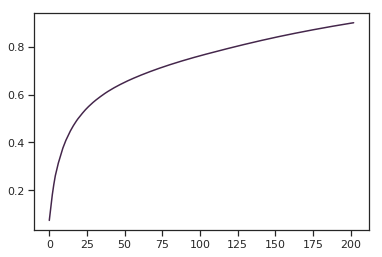

In [18]:
cum_var_expl = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(data = cum_var_expl)
plt.xlabel = "Number of dimensions"
plt.ylabel = "Variance explained"

In [19]:
pca.n_components_

203

In [20]:
pca.n_features_

653

In [21]:
pca.get_params

<bound method BaseEstimator.get_params of PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)>